# Customer Churn Analysis Notebook

## 1. Introduction and Setup

In [1]:
# Import the modules we've created
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
# Add project root to Python path to fix import issues
import sys
import os

# Get the current working directory and add the parent directory to Python path
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)


# Import our custom modules
from src.data_processing import DataProcessor
from src.train import ModelTrainer
from src.predict import ChurnPredictor
from src.database import Database
import joblib

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Initialize components
data_processor = DataProcessor("../config.yaml")
trainer = ModelTrainer("../config.yaml")
predictor = ChurnPredictor("../config.yaml")

## 2. Exploratory Data Analysis (EDA)

In [2]:
# Load data using our data processor
df = data_processor.load_data("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Clean the data
df_clean = data_processor.clean_data(df)

# Display basic information
print(f"Dataset shape: {df_clean.shape}")
print(f"\nChurn distribution:")
print(df_clean['Churn'].value_counts(normalize=True))

INFO:src.data_processing:Data loaded successfully from ../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv. Shape: (7043, 21)
INFO:src.data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)


Dataset shape: (7043, 21)

Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


### Churn rate visualization


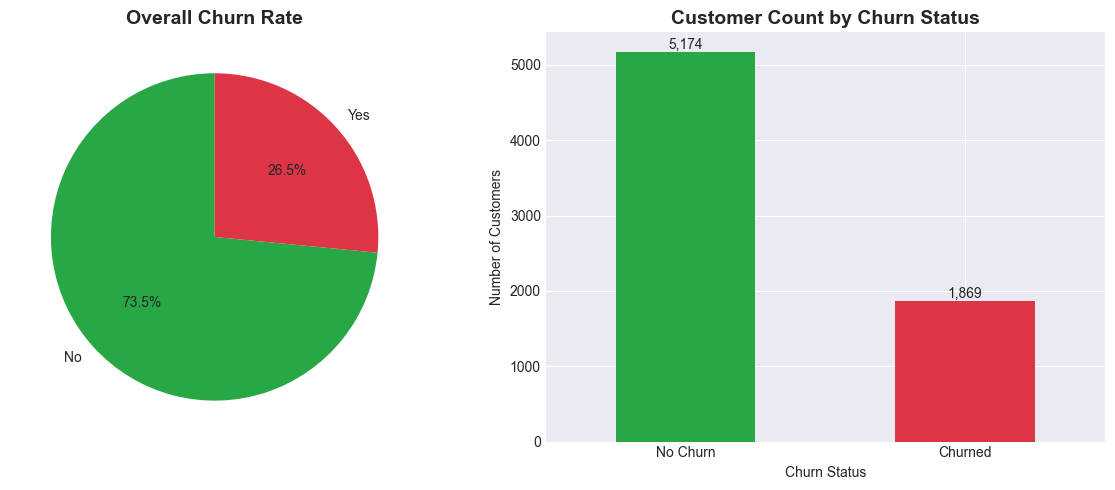

In [3]:
# Overall churn rate
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart
churn_counts = df_clean['Churn'].value_counts()
axes[0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', 
            colors=['#28a745', '#dc3545'], startangle=90)
axes[0].set_title('Overall Churn Rate', fontsize=14, fontweight='bold')

# Bar chart with actual numbers
ax = churn_counts.plot(kind='bar', ax=axes[1], color=['#28a745', '#dc3545'])
axes[1].set_title('Customer Count by Churn Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Churn Status')
axes[1].set_ylabel('Number of Customers')
axes[1].set_xticklabels(['No Churn', 'Churned'], rotation=0)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Feature distributions


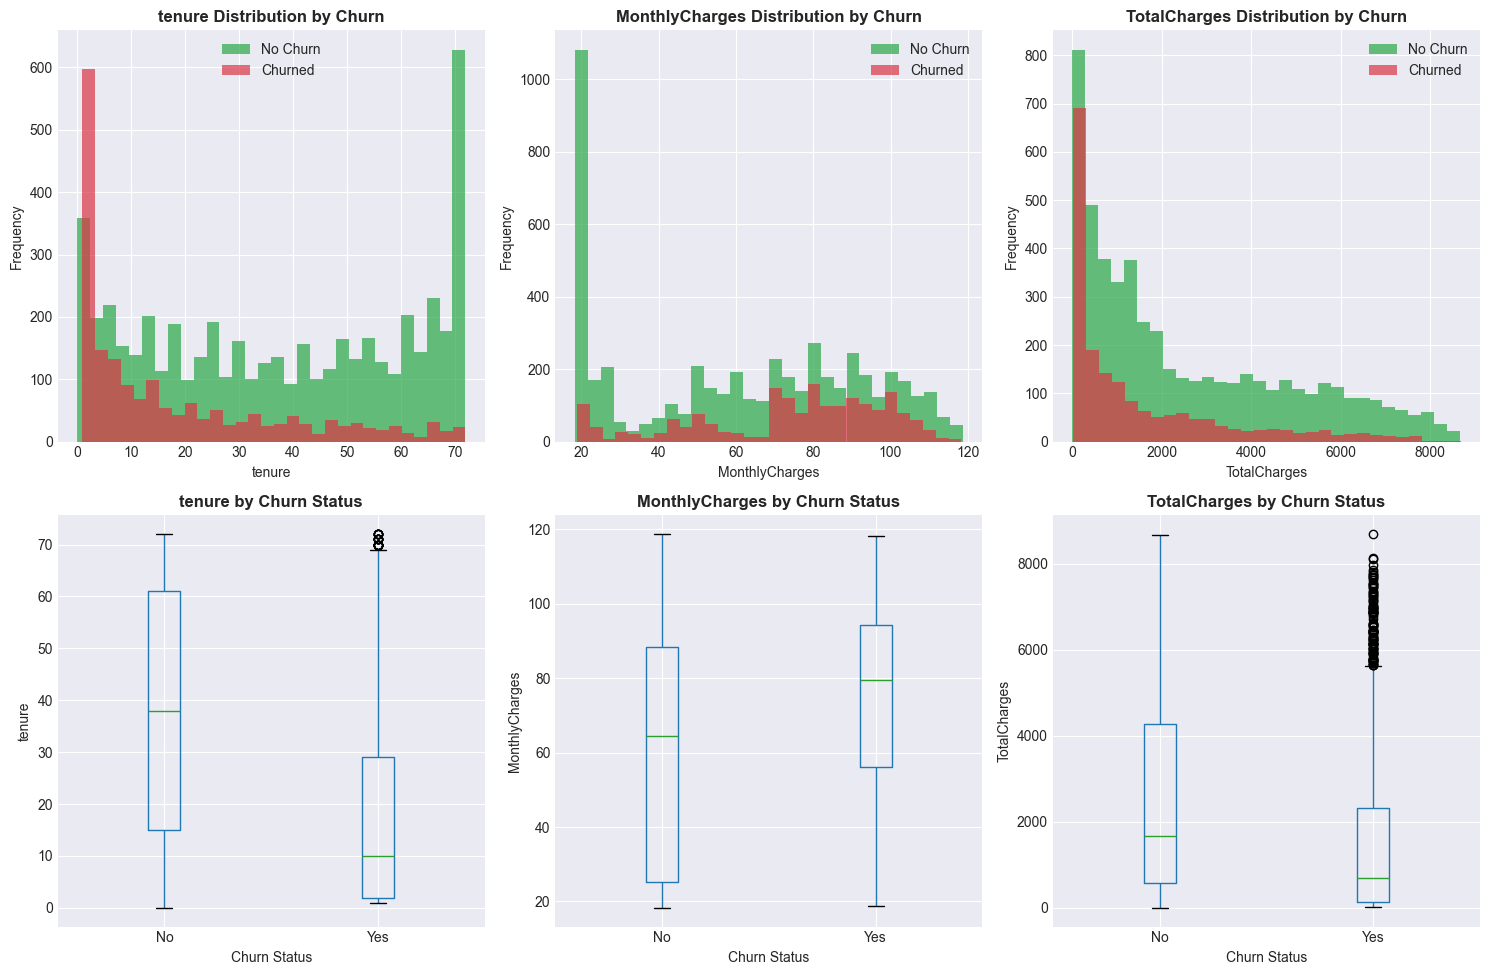

In [4]:
# Numeric feature distributions
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features):
    # Distribution plot
    df_clean[df_clean['Churn'] == 'No'][feature].hist(bins=30, alpha=0.7, 
                                                      label='No Churn', 
                                                      ax=axes[idx], 
                                                      color='#28a745')
    df_clean[df_clean['Churn'] == 'Yes'][feature].hist(bins=30, alpha=0.7, 
                                                       label='Churned', 
                                                       ax=axes[idx], 
                                                       color='#dc3545')
    axes[idx].set_title(f'{feature} Distribution by Churn', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    
    # Box plot
    df_clean.boxplot(column=feature, by='Churn', ax=axes[idx+3])
    axes[idx+3].set_title(f'{feature} by Churn Status', fontweight='bold')
    axes[idx+3].set_xlabel('Churn Status')
    axes[idx+3].set_ylabel(feature)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

### Correlation analysis


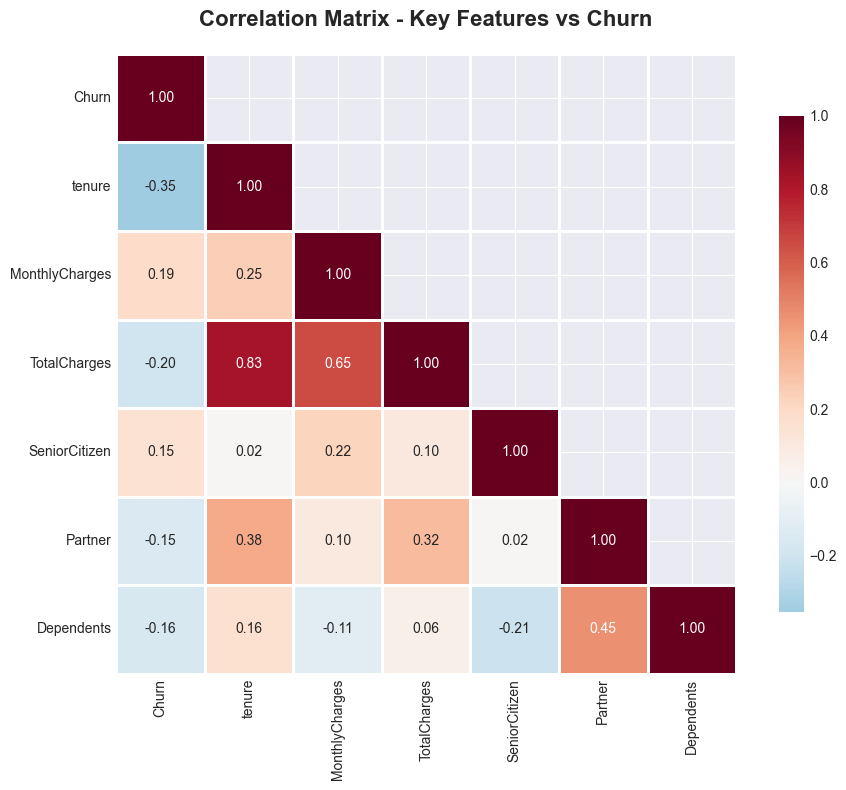

Features most correlated with Churn:
MonthlyCharges    0.193356
SeniorCitizen     0.150889
Partner          -0.150448
Dependents       -0.164221
TotalCharges     -0.198324
tenure           -0.352229
Name: Churn, dtype: float64


In [5]:

# Prepare data for correlation analysis
# Convert categorical variables to numeric
df_corr = df_clean.copy()
df_corr['Churn'] = (df_corr['Churn'] == 'Yes').astype(int)
df_corr['gender'] = (df_corr['gender'] == 'Male').astype(int)
df_corr['Partner'] = (df_corr['Partner'] == 'Yes').astype(int)
df_corr['Dependents'] = (df_corr['Dependents'] == 'Yes').astype(int)
df_corr['PhoneService'] = (df_corr['PhoneService'] == 'Yes').astype(int)
df_corr['PaperlessBilling'] = (df_corr['PaperlessBilling'] == 'Yes').astype(int)

# Select numeric columns for correlation
corr_columns = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges', 
                'SeniorCitizen', 'Partner', 'Dependents']

# Calculate correlation matrix
correlation_matrix = df_corr[corr_columns].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Key Features vs Churn', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Show features most correlated with churn
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("Features most correlated with Churn:")
print(churn_correlations[1:])  # Exclude self-correlation

### Contract type analysis


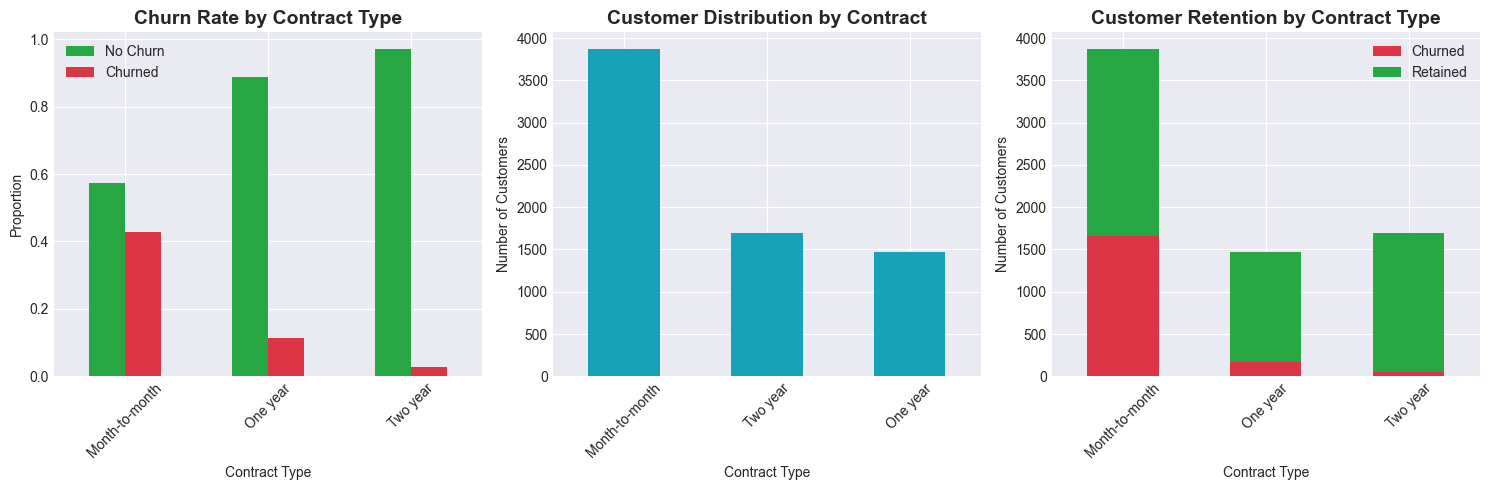

Churn Rate by Contract Type:
Month-to-month: 42.7%
One year: 11.3%
Two year: 2.8%


In [6]:
# Contract type vs Churn
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Churn rate by contract type
contract_churn = df_clean.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
contract_churn.plot(kind='bar', ax=axes[0], color=['#28a745', '#dc3545'])
axes[0].set_title('Churn Rate by Contract Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Proportion')
axes[0].legend(['No Churn', 'Churned'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Customer count by contract type
contract_counts = df_clean['Contract'].value_counts()
contract_counts.plot(kind='bar', ax=axes[1], color='#17a2b8')
axes[1].set_title('Customer Distribution by Contract', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Contract Type')
axes[1].set_ylabel('Number of Customers')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Churn numbers by contract type (absolute)
contract_churn_abs = df_clean[df_clean['Churn'] == 'Yes'].groupby('Contract').size()
total_customers = df_clean.groupby('Contract').size()
churn_data = pd.DataFrame({
    'Churned': contract_churn_abs,
    'Retained': total_customers - contract_churn_abs
})
churn_data.plot(kind='bar', stacked=True, ax=axes[2], color=['#dc3545', '#28a745'])
axes[2].set_title('Customer Retention by Contract Type', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Contract Type')
axes[2].set_ylabel('Number of Customers')
axes[2].legend(['Churned', 'Retained'])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print("Churn Rate by Contract Type:")
for contract in df_clean['Contract'].unique():
    churn_rate = (df_clean[df_clean['Contract'] == contract]['Churn'] == 'Yes').mean() * 100
    print(f"{contract}: {churn_rate:.1f}%")

### Tenure analysis


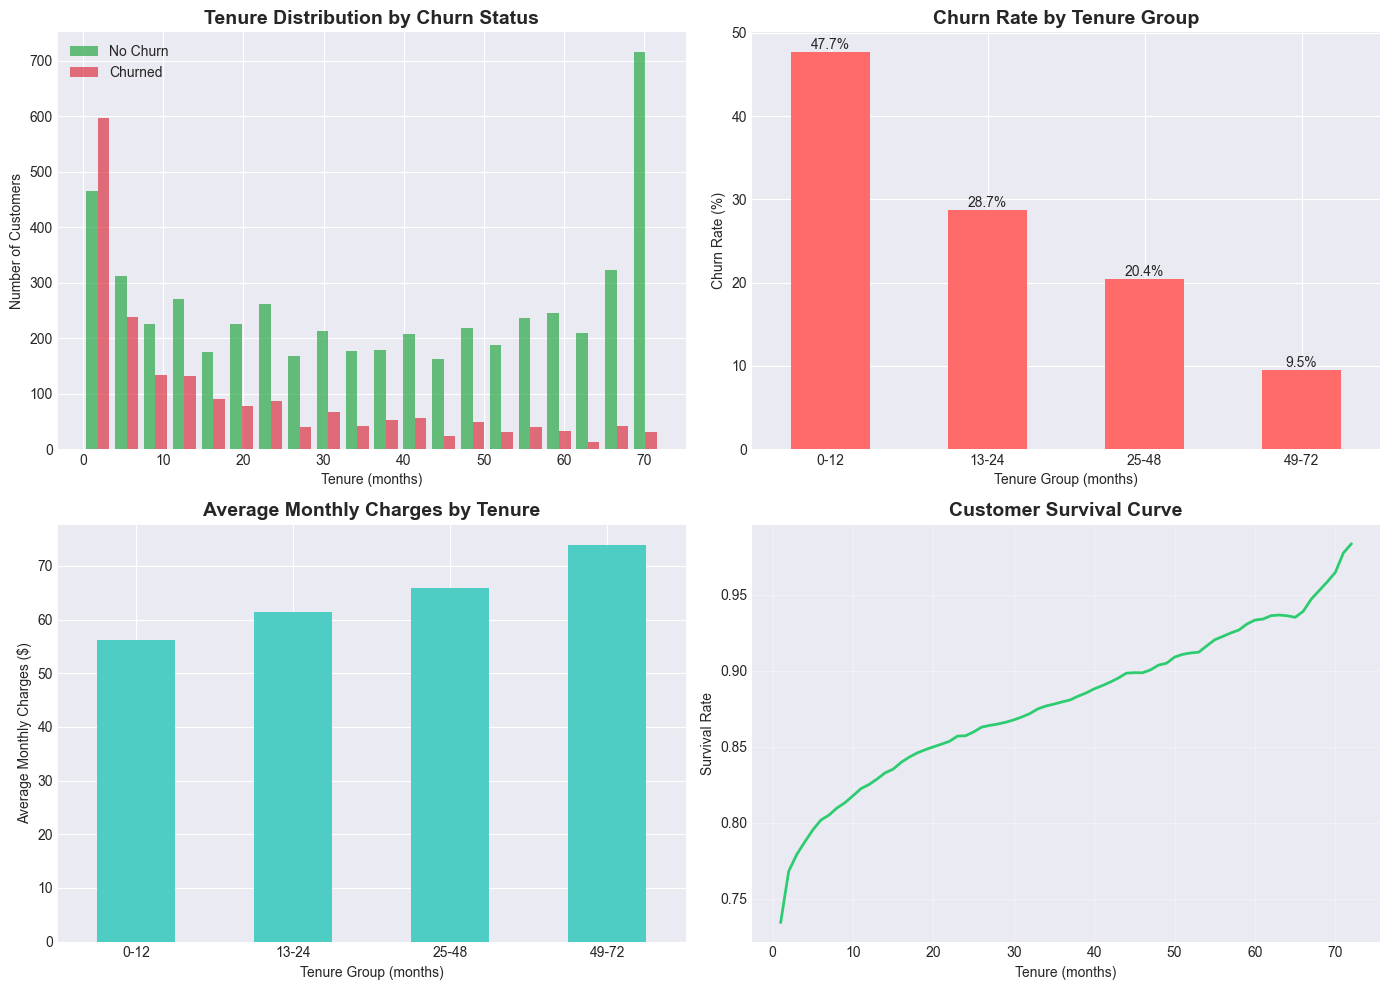

In [7]:
# Tenure analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Tenure distribution by churn
axes[0, 0].hist([df_clean[df_clean['Churn'] == 'No']['tenure'],
                 df_clean[df_clean['Churn'] == 'Yes']['tenure']], 
                bins=20, alpha=0.7, label=['No Churn', 'Churned'],
                color=['#28a745', '#dc3545'])
axes[0, 0].set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Tenure (months)')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].legend()

# Churn rate by tenure groups
tenure_groups = pd.cut(df_clean['tenure'], 
                      bins=[0, 12, 24, 48, 72], 
                      labels=['0-12', '13-24', '25-48', '49-72'])
churn_by_tenure = df_clean.groupby(tenure_groups, observed=False)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)

churn_by_tenure.plot(kind='bar', ax=axes[0, 1], color='#ff6b6b')
axes[0, 1].set_title('Churn Rate by Tenure Group', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Tenure Group (months)')
axes[0, 1].set_ylabel('Churn Rate (%)')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# Add value labels
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.1f}%', 
                       (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='bottom')

# Average monthly charges by tenure group
avg_charges_by_tenure = df_clean.groupby(tenure_groups, observed=False)['MonthlyCharges'].mean()
avg_charges_by_tenure.plot(kind='bar', ax=axes[1, 0], color='#4ecdc4')
axes[1, 0].set_title('Average Monthly Charges by Tenure', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Tenure Group (months)')
axes[1, 0].set_ylabel('Average Monthly Charges ($)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

# Survival curve (customers retained over time)
max_tenure = df_clean['tenure'].max()
survival_data = []
for t in range(1, max_tenure + 1):
    retained = (df_clean[df_clean['tenure'] >= t]['Churn'] == 'No').sum()
    total = (df_clean['tenure'] >= t).sum()
    survival_rate = retained / total if total > 0 else 0
    survival_data.append(survival_rate)


axes[1, 1].plot(range(1, max_tenure + 1), survival_data, color='#2ecc71', linewidth=2)
axes[1, 1].set_title('Customer Survival Curve', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Tenure (months)')
axes[1, 1].set_ylabel('Survival Rate')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Service usage patterns

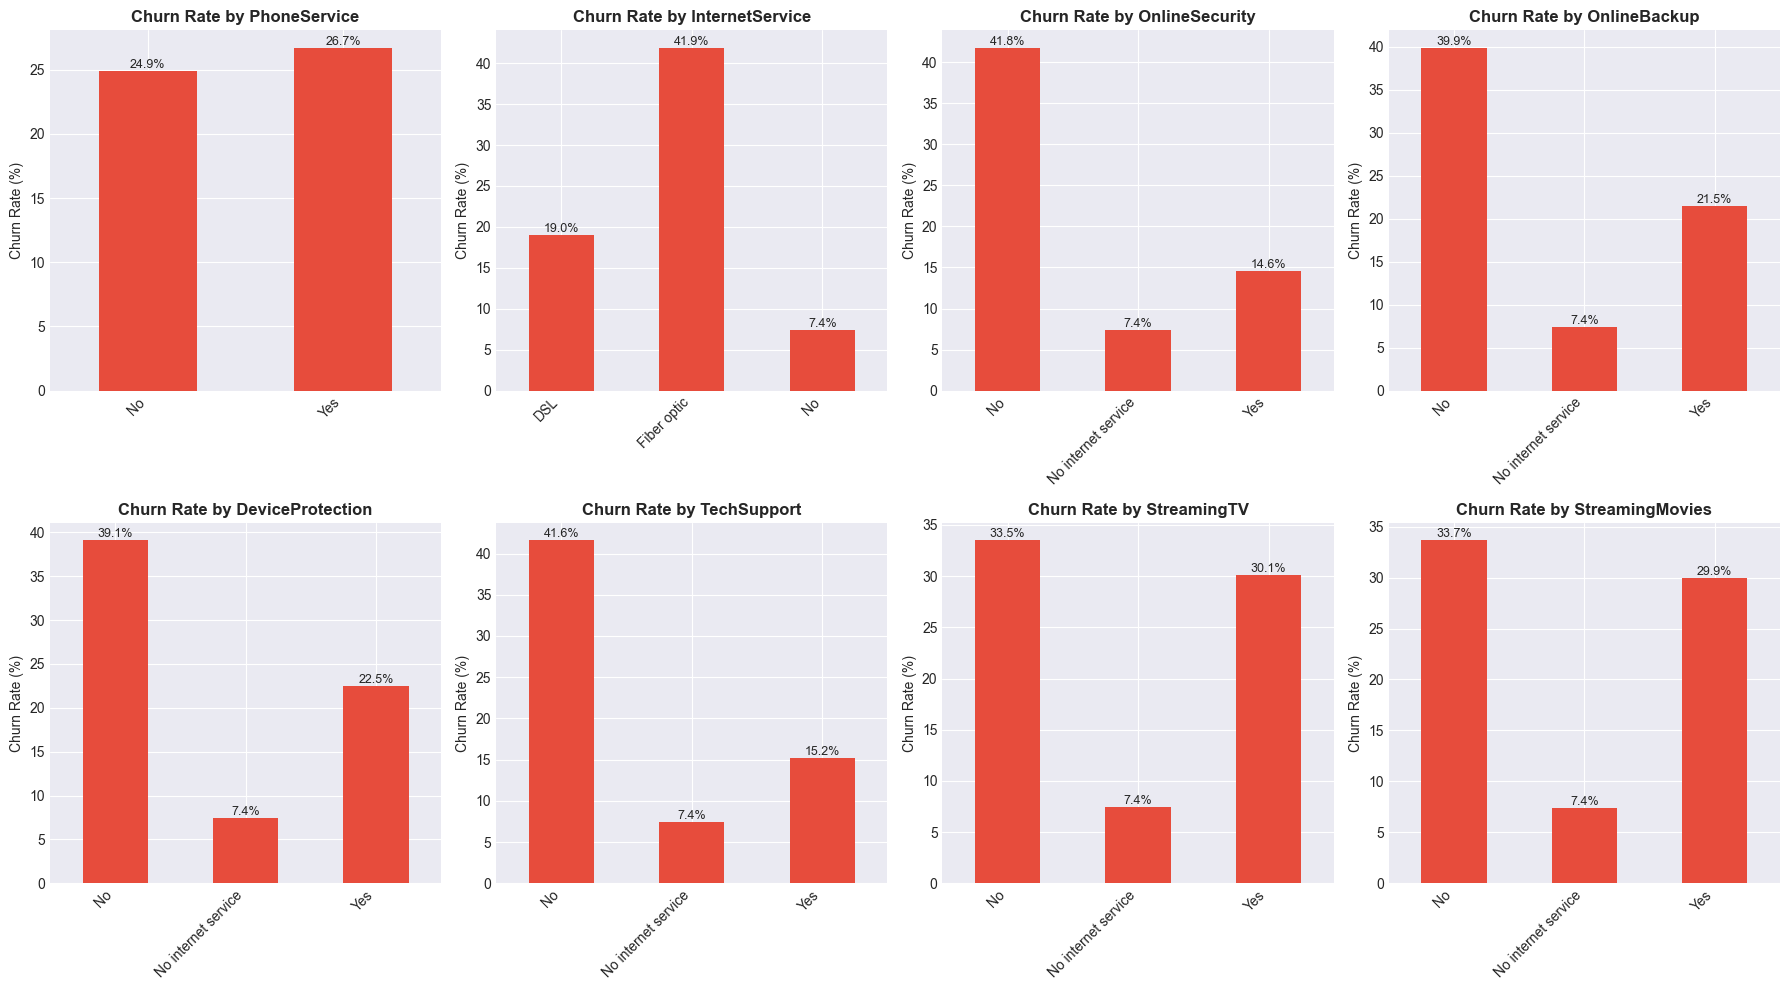

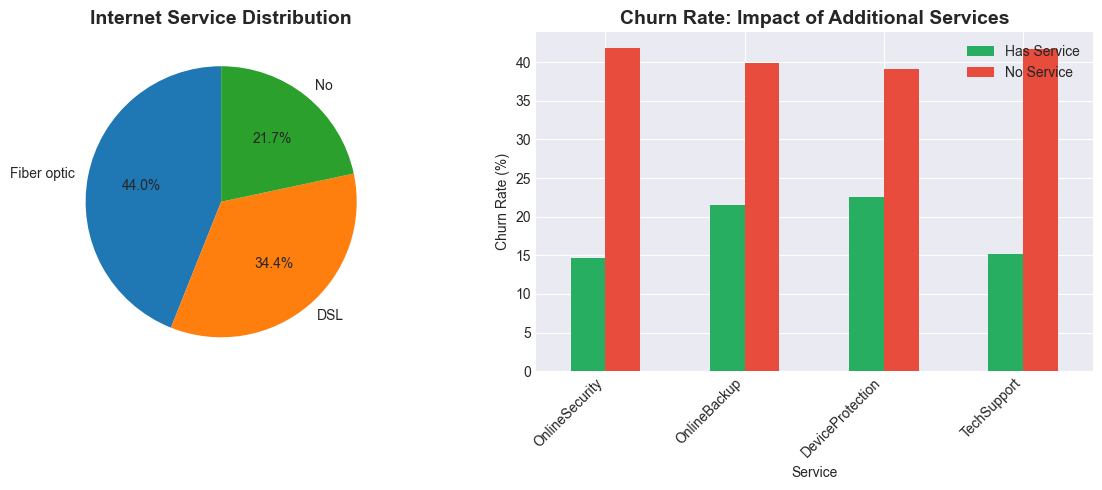

In [8]:
services = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.ravel()

for idx, service in enumerate(services):
    # Calculate churn rate for each service category
    service_churn = df_clean.groupby(service)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    
    # Plot
    service_churn.plot(kind='bar', ax=axes[idx], color='#e74c3c')
    axes[idx].set_title(f'Churn Rate by {service}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Churn Rate (%)')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for p in axes[idx].patches:
        axes[idx].annotate(f'{p.get_height():.1f}%', 
                          (p.get_x() + p.get_width()/2., p.get_height()),
                          ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Internet service deep dive
if 'InternetService' in df_clean.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Internet service distribution
    internet_counts = df_clean['InternetService'].value_counts()
    axes[0].pie(internet_counts.values, labels=internet_counts.index, 
                autopct='%1.1f%%', startangle=90)
    axes[0].set_title('Internet Service Distribution', fontsize=14, fontweight='bold')
    
    # Churn by internet service and additional services
    internet_users = df_clean[df_clean['InternetService'] != 'No']
    additional_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
    
    service_impact = {}
    for service in additional_services:
        has_service = internet_users[internet_users[service] == 'Yes']['Churn'].eq('Yes').mean()
        no_service = internet_users[internet_users[service] == 'No']['Churn'].eq('Yes').mean()
        service_impact[service] = {'Has Service': has_service * 100, 'No Service': no_service * 100}
    
    impact_df = pd.DataFrame(service_impact).T
    impact_df.plot(kind='bar', ax=axes[1], color=['#27ae60', '#e74c3c'])
    axes[1].set_title('Churn Rate: Impact of Additional Services', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Service')
    axes[1].set_ylabel('Churn Rate (%)')
    axes[1].legend(['Has Service', 'No Service'])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

## 3. Feature Engineering Demonstration

In [9]:
# Add engineered features
df_engineered = data_processor.calculate_derived_features(df_clean)
# Fix data types for consistency
df_engineered['SeniorCitizen'] = df_engineered['SeniorCitizen'].astype('object')
df_engineered['HasInternetService'] = df_engineered['HasInternetService'].astype('object')

# Show new features
print("New engineered features:")
print(df_engineered[['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']].head(10))
print("\nFeature statistics:")
print(df_engineered[['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']].describe())




# Statistical significance of engineered features
print("\n" + "="*50)
print("Statistical Analysis of Engineered Features")
print("="*50)




INFO:src.data_processing:Created MonthlyToTotalRatio feature
INFO:src.data_processing:Created NumAdditionalServices feature
INFO:src.data_processing:Dropped original service columns: ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
INFO:src.data_processing:Created HasInternetService feature
INFO:src.data_processing:Dropped original InternetService column


New engineered features:
   MonthlyToTotalRatio  NumAdditionalServices HasInternetService
0             1.000000                      1                  1
1             0.030140                      2                  1
2             0.497920                      2                  1
3             0.022980                      3                  1
4             0.466205                      0                  1
5             0.121450                      3                  1
6             0.045706                      2                  1
7             0.098543                      1                  1
8             0.034405                      4                  1
9             0.016098                      2                  1

Feature statistics:
       MonthlyToTotalRatio  NumAdditionalServices
count          7043.000000            7043.000000
mean              0.158908               2.037910
std               0.283248               1.847682
min               0.012604             

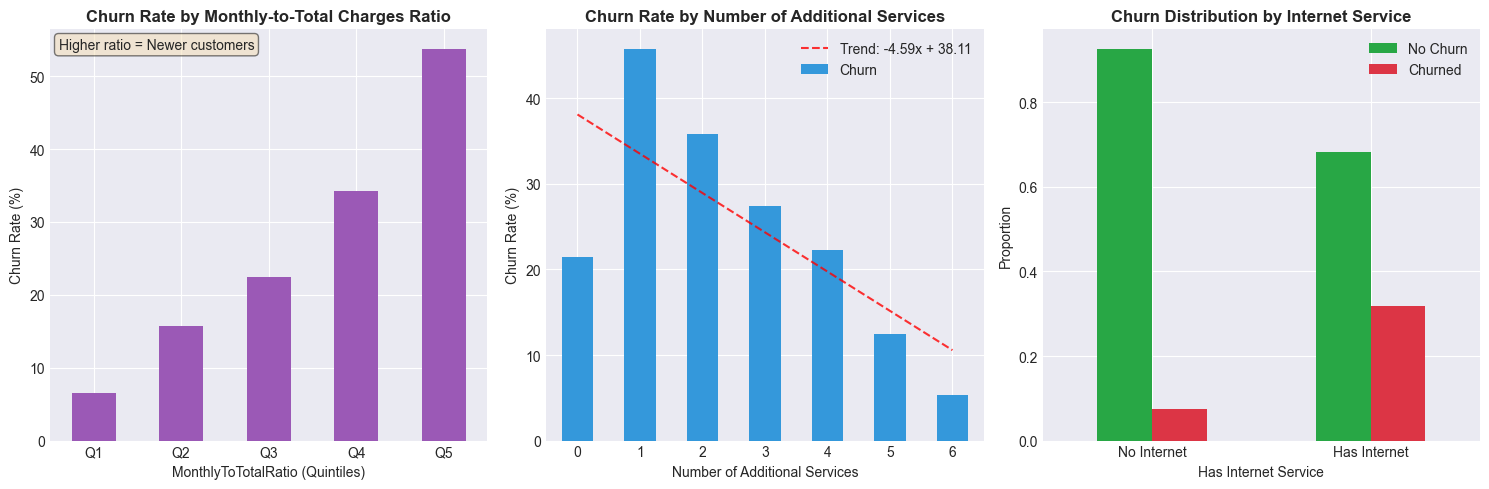

In [10]:
from scipy import stats

# Convert Churn to binary for analysis make compy of df_engineered
df_engineered_false = df_engineered.copy()
df_engineered_false['Churn_Binary'] = (df_engineered_false['Churn'] == 'Yes').astype(int)


# Visualize the impact of engineered features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. MonthlyToTotalRatio vs Churn
ratio_bins = pd.qcut(df_engineered_false['MonthlyToTotalRatio'], q=5, duplicates='drop')
churn_by_ratio = df_engineered_false.groupby(ratio_bins, observed=False)['Churn_Binary'].apply(lambda x: (x == 1).mean() * 100)

churn_by_ratio.plot(kind='bar', ax=axes[0], color='#9b59b6')
axes[0].set_title('Churn Rate by Monthly-to-Total Charges Ratio', fontsize=12, fontweight='bold')
axes[0].set_xlabel('MonthlyToTotalRatio (Quintiles)')
axes[0].set_ylabel('Churn Rate (%)')
axes[0].set_xticklabels([f'Q{i+1}' for i in range(len(churn_by_ratio))], rotation=0)

# Add interpretation text
axes[0].text(0.02, 0.98, 'Higher ratio = Newer customers', 
             transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. NumAdditionalServices vs Churn
# Calculate the churn rate by taking the mean of boolean values (True for 'Yes')
churn_rate_by_services = df_engineered.groupby('NumAdditionalServices')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)

churn_rate_by_services.plot(kind='bar', ax=axes[1], color='#3498db')
axes[1].set_title('Churn Rate by Number of Additional Services', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Additional Services')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Add trend line
# Use the index and values from the new 'churn_rate_by_services' Series
z = np.polyfit(churn_rate_by_services.index, churn_rate_by_services.values, 1)
p = np.poly1d(z)
axes[1].plot(churn_rate_by_services.index, p(churn_rate_by_services.index), "r--", alpha=0.8, label=f'Trend: {z[0]:.2f}x + {z[1]:.2f}')
axes[1].legend()
# 3. HasInternetService vs Churn
internet_churn = df_engineered.groupby('HasInternetService')['Churn'].value_counts(normalize=True).unstack()
internet_churn.plot(kind='bar', ax=axes[2], color=['#28a745', '#dc3545'])
axes[2].set_title('Churn Distribution by Internet Service', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Has Internet Service')
axes[2].set_ylabel('Proportion')
axes[2].set_xticklabels(['No Internet', 'Has Internet'], rotation=0)
axes[2].legend(['No Churn', 'Churned'])

plt.tight_layout()
plt.show()


In [11]:

# T-test for MonthlyToTotalRatio
churned_ratio = df_engineered_false[df_engineered_false['Churn_Binary'] == 1]['MonthlyToTotalRatio']
not_churned_ratio = df_engineered_false[df_engineered_false['Churn_Binary'] == 0]['MonthlyToTotalRatio']
t_stat, p_value = stats.ttest_ind(churned_ratio.dropna(), not_churned_ratio.dropna())
print(f"\nMonthlyToTotalRatio T-test:")
print(f"  Mean (Churned): {churned_ratio.mean():.4f}")
print(f"  Mean (Not Churned): {not_churned_ratio.mean():.4f}")
print(f"  T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")

# T-test for NumAdditionalServices
churned_services = df_engineered_false[df_engineered_false['Churn_Binary'] == 1]['NumAdditionalServices']
not_churned_services = df_engineered_false[df_engineered_false['Churn_Binary'] == 0]['NumAdditionalServices']
t_stat, p_value = stats.ttest_ind(churned_services, not_churned_services)
print(f"\nNumAdditionalServices T-test:")
print(f"  Mean (Churned): {churned_services.mean():.2f}")
print(f"  Mean (Not Churned): {not_churned_services.mean():.2f}")
print(f"  T-statistic: {t_stat:.4f}, p-value: {p_value:.4e}")

# Chi-square test for HasInternetService
crosstab = pd.crosstab(df_engineered_false['HasInternetService'], df_engineered_false['Churn_Binary'])
chi2, p_value, dof, expected = stats.chi2_contingency(crosstab)
print(f"\nHasInternetService Chi-square test:")
print(f"  Chi-square statistic: {chi2:.4f}, p-value: {p_value:.4e}")

# Feature correlation with target
print("\nCorrelation with Churn:")
engineered_features = ['MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService']
for feature in engineered_features:
    corr = df_engineered_false[feature].corr(df_engineered_false['Churn_Binary'])
    print(f"  {feature}: {corr:.4f}")


MonthlyToTotalRatio T-test:
  Mean (Churned): 0.3066
  Mean (Not Churned): 0.1055
  T-statistic: 27.6979, p-value: 2.2767e-160

NumAdditionalServices T-test:
  Mean (Churned): 1.77
  Mean (Not Churned): 2.14
  T-statistic: -7.3873, p-value: 1.6714e-13

HasInternetService Chi-square test:
  Chi-square statistic: 364.5198, p-value: 2.9203e-81

Correlation with Churn:
  MonthlyToTotalRatio: 0.3135
  NumAdditionalServices: -0.0877
  HasInternetService: 0.2279


The decision to retain all three engineered features—MonthlyToTotalRatio, HasInternetService, and especially NumAdditionalServices—is motivated by a data-driven and model-centric approach. While MonthlyToTotalRatio and HasInternetService show strong initial correlations, NumAdditionalServices is kept because of its extremely high statistical significance (a p-value near zero). This indicates that while its linear relationship to churn is weak, the patterns it holds are real and not due to random chance. Advanced models like Random Forest and Gradient Boosting excel at uncovering such complex, non-linear relationships and feature interactions. Therefore, this strategy prioritizes statistical significance to provide the models with the richest possible feature set, allowing them to determine the ultimate predictive importance during the training and tuning process.

## 4. Data Validation and Quality Checks

In [12]:
#df_engineered['TotalCharges'] = df_engineered['TotalCharges'].fillna(0)

# Validate data quality
validation_issues = data_processor.validate_data(df_engineered)

print("Data Validation Report:")
for issue_type, issues in validation_issues.items():
    if issues:
        print(f"\n{issue_type}:")
        for issue in issues:
            print(f"  - {issue}")
            


Data Validation Report:

missing_columns:
  - InternetService
  - OnlineSecurity
  - OnlineBackup
  - DeviceProtection
  - TechSupport
  - StreamingTV
  - StreamingMovies


## 5. Model Training Process

In [13]:


X, y = data_processor.prepare_features(df_engineered)

# Split data
X_train, X_test, y_train, y_test = trainer.split_data(X, y)



INFO:src.train:Data split - Train: (5634, 15), Test: (1409, 15)
INFO:src.train:Class distribution - Train: {'No': 4139, 'Yes': 1495}
INFO:src.train:Class distribution - Test: {'No': 1035, 'Yes': 374}


In [14]:
print(X_train.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'MonthlyToTotalRatio', 'NumAdditionalServices', 'HasInternetService'],
      dtype='object')


In [15]:
with open('../models/best_hyperparameters.json', 'r') as f:
    best_params = json.load(f)

# Train fresh models using the function
results, best_model_name, best_score = trainer.train_fresh_models(X_train, X_test, y_train, y_test, best_params)



INFO:src.train:
Training Fresh Models with Best Hyperparameters
INFO:src.train:
Training random_forest...
INFO:src.data_processing:Created preprocessing pipeline
INFO:src.train:
random_forest Test Performance:
INFO:src.train:F1 Score: 0.6297
INFO:src.train:Recall: 0.7888
INFO:src.train:ROC AUC: 0.8440
INFO:src.train:Finished training random_forest.
INFO:src.train:
Training xgboost...
INFO:src.data_processing:Created preprocessing pipeline
INFO:src.train:
xgboost Test Performance:
INFO:src.train:F1 Score: 0.6341
INFO:src.train:Recall: 0.6952
INFO:src.train:ROC AUC: 0.8468
INFO:src.train:Finished training xgboost.
INFO:src.train:
Training gradient_boosting...
INFO:src.data_processing:Created preprocessing pipeline
INFO:src.train:
gradient_boosting Test Performance:
INFO:src.train:F1 Score: 0.6218
INFO:src.train:Recall: 0.7406
INFO:src.train:ROC AUC: 0.8373
INFO:src.train:Finished training gradient_boosting.
INFO:src.train:
Training logistic...
INFO:src.data_processing:Created preprocessi

In [16]:
#save all models
# Save all trained models
for model_name, model_results in results.items():
    model_path = f'../models/{model_name}_model.pkl'
    joblib.dump(model_results['pipeline'], model_path)
    print(f"Saved {model_name} model to {model_path}")

print(f"\nBest model ({best_model_name}) saved and ready for predictions!")


Saved random_forest model to ../models/random_forest_model.pkl
Saved xgboost model to ../models/xgboost_model.pkl
Saved gradient_boosting model to ../models/gradient_boosting_model.pkl
Saved logistic model to ../models/logistic_model.pkl

Best model (xgboost) saved and ready for predictions!


## 6. Model Performance Visualization

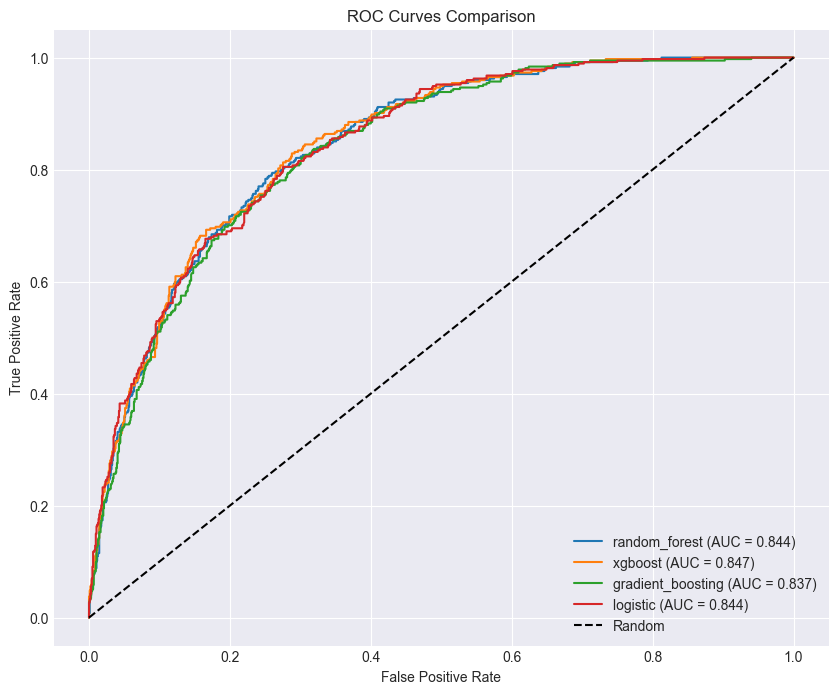

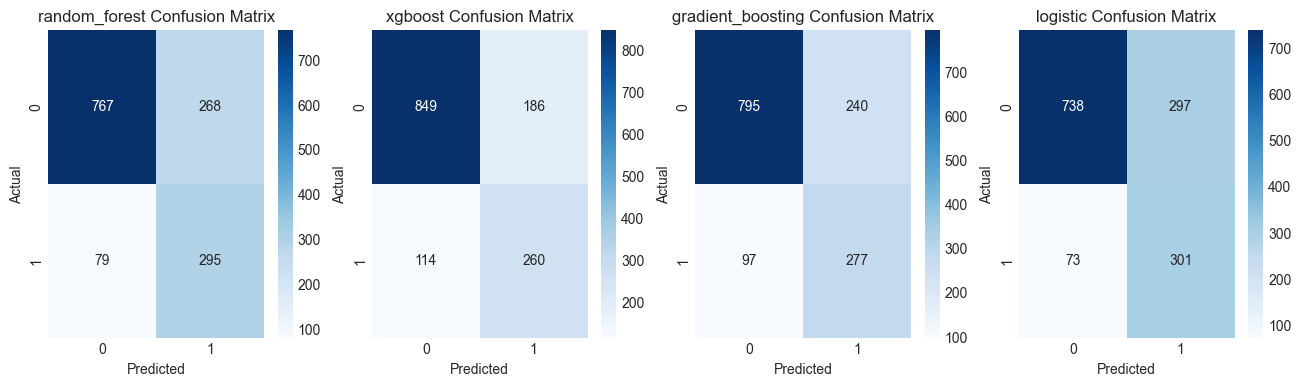

In [17]:
# ROC Curves comparison
plt.figure(figsize=(10, 8))
for model_name, model_results in results.items():
    roc_data = model_results['roc_curve']
    plt.plot(roc_data['fpr'], roc_data['tpr'], 
             label=f'{model_name} (AUC = {model_results["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for idx, (model_name, model_results) in enumerate(results.items()):
    cm = model_results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{model_name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

## 7. Feature Importance Analysis

In [18]:
# Get the best model pipelin
best_pipeline = results[best_model_name]['pipeline']

# Extract feature names after preprocessing
preprocessor = best_pipeline.named_steps.get('preprocessor')
feature_names = preprocessor.get_feature_names_out()


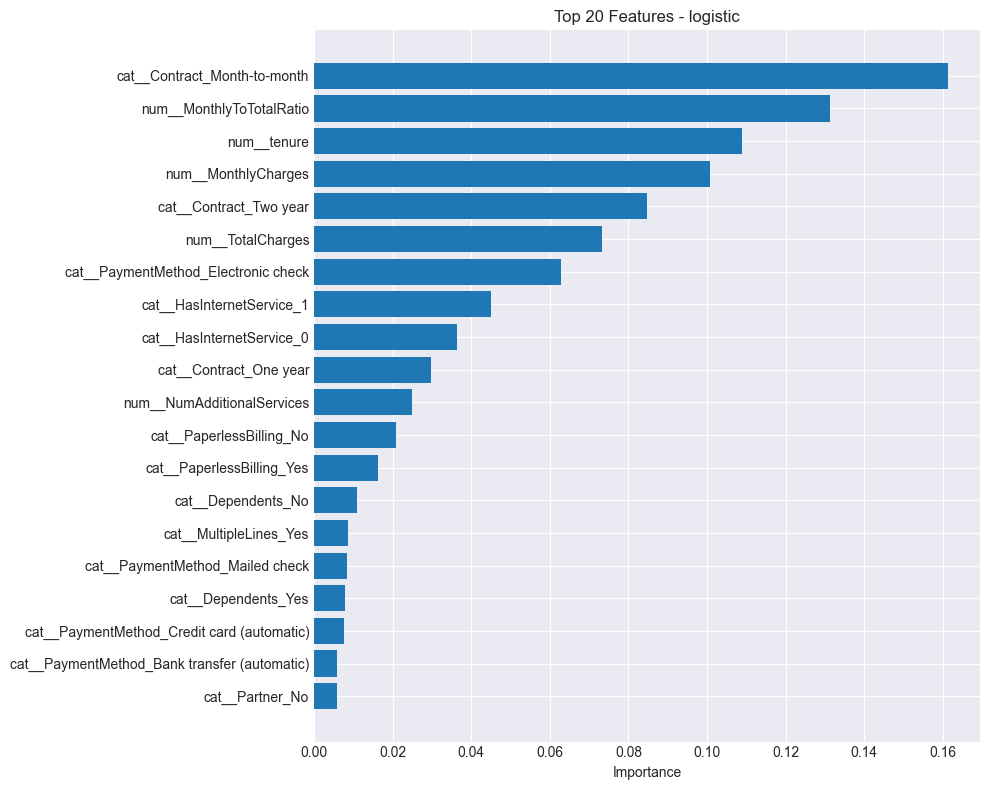

In [19]:
random_forest_pipeline = results['random_forest']['pipeline']
# Extract feature names after preprocessing
random_forest_preprocessor = random_forest_pipeline.named_steps.get('preprocessor')
random_forest_feature_names = random_forest_preprocessor.get_feature_names_out()


random_forest_importance_df = trainer.get_feature_importance(random_forest_pipeline, random_forest_feature_names)
    
    # Visualize top features
top_features = random_forest_importance_df.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title(f'Top 20 Features - {model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Making Predictions (DEMO)

In [20]:
#load model


# Load a trained model first
model_loaded = predictor.load_model("../models/xgboost_model.pkl")


if model_loaded:
    print("Model loaded successfully!")
else:
    print("Failed to load any model. Please check if models exist in the models directory.")


# Example: High-risk customer profile
high_risk_customer = {
    "customerID": "DEMO-001",
    "gender": "Male",
    "SeniorCitizen": 0,
    "Partner": "No",
    "Dependents": "No",
    "tenure": 2,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "No",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "No",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 85.0,
    "TotalCharges": 170.0,
    "MonthlyToTotalRatio": 0.5,
    "NumAdditionalServices": 0,
    "HasInternetService": "Yes"
}

# Get prediction with explanation
result = predictor.predict_single(high_risk_customer)
explanation = predictor.explain_prediction(high_risk_customer)

print("Prediction Results:")
print(f"Churn Prediction: {result['churn_prediction']}")
print(f"Churn Probability: {result['churn_probability']:.3f}")
print(f"Risk Level: {result['risk_level']}")

print("\nImportant Factors:")
for factor in explanation['important_factors']:
    print(f"  - {factor}")

print("\nRetention Recommendations:")
for rec in explanation['recommendations']:
    print(f"  - {rec}")

INFO:src.predict:Model loaded successfully from ../models/xgboost_model.pkl
INFO:src.data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)
INFO:src.data_processing:Created MonthlyToTotalRatio feature
INFO:src.data_processing:Created NumAdditionalServices feature
INFO:src.data_processing:Dropped original service columns: ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
INFO:src.data_processing:Created HasInternetService feature
INFO:src.data_processing:Dropped original InternetService column
INFO:src.predict:Batch prediction complete: 1 customers, 1 predicted to churn (100.0%)
INFO:src.data_processing:Converted and imputed TotalCharges. Found 0 remaining missing values (should be 0)
INFO:src.data_processing:Created MonthlyToTotalRatio feature
INFO:src.data_processing:Created NumAdditionalServices feature
INFO:src.data_processing:Dropped original service columns: ['OnlineSecurity', 'Online

Model loaded successfully!
Prediction Results:
Churn Prediction: Yes
Churn Probability: 0.841
Risk Level: Very High

Important Factors:
  - Month-to-month contract (higher churn risk)
  - New customer (tenure: 2 months)
  - Electronic check payment (associated with higher churn)
  - No online security service
  - No tech support service
  - High monthly charges ($85.00)

Retention Recommendations:
  - Offer incentive to switch to annual contract
  - Implement new customer retention program
  - Bundle additional services with discount
  - Review pricing and offer competitive rate
  - Priority intervention - personal outreach recommended
